# init

In [ ]:
!nvidia-smi

Sun Oct 24 06:43:29 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.74       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P0    22W / 300W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
from google.colab import drive
# mount google drive 
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# 환경, 경로 등
import os
import sys
import argparse # 위치, 옵션 등을 활용하는 모듈
import shutil
from glob import glob as gb
# from setuptools import setup, Extension # def, class 작성 이후
import warnings
warnings.filterwarnings("ignore")

# 비동기, 속도 등
import tqdm
# import time
import timeit
# timeit.timeit(~), timeit.Timer(~)
import numba
import asyncio
# from abc import * # 부모 클래스(추상 클래스)에서 꼭 만들었으면 하는 매서드를 강제하기 위함, asyncio랑 뭐가 다른겨?? 'parents(metaclass=ABCMeta)' : {,...,\n'@abstractmethod\nmethod_name(self)':~~}

# 이미지
import base64
import PIL
import numpy as np
import cv2 as cv
import scipy.io
import scipy.misc
from skimage.color import rgb2gray

# 모델
import torch
import torch.nn as nn
import torch.utils.checkpoint as cp
from torch.nn.modules.batchnorm import _BatchNorm

# 결과 도출
# import json
from flask import json

# 시각화 - 모델 조율, 더블 체크 등에 활용
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
%matplotlib inline

# R
from rpy2.robjects import r
%load_ext rpy2.ipython

* Infos :
  * data : 30 sample images only(without annotations)
* transfer -> Color Ch., Gaussian Blur, Dodge, Sponge
* Conditions :
  * time max. 120 mins
  * vCPU(4 cores), MEM(30GB), GPU(P40-24GB)
  * 해당 도커는 MEM의 제한(25GB)만 두고 있으며, 4차대회는 트랙에 상관없이 GPU 6GB로 제한

경량화, 속도가 관건이긴 한데...
일주일 앞둔 시점에서 도커 환경(서버 가상 공간)에서 유의해야 할 부분 + 제약 사항들 고려하면서, 다같이 모델 구조 픽스 및 구성
주최 측이 평가한다던, $macro\,F1\,Score$가 class probability map이랑 유사한 원리일 것이라 생각됨.

main.py 에서 레포지토리나 디렉토리로 연결되는 방식.

```bash
%%bash
# bash ~.sh
# toml or yml -> command line
# 작성해야할 리눅스 명령어는 도커 빌드하면서 연습해보고 정리하기 <- p.s. colab에는 거의 셋업이 되어 있음
```

In [4]:
path = "drive/MyDrive/Task/Proj_Caliber/dataset"
img_paths = sorted(gb(path+'/train/*.JPG'))
img_names = [imgs.split('/')[-1] for imgs in img_paths]

# Check Images

In [5]:
def cv_imshow(a, **kwargs):
    a = a.clip(0, 255).astype('uint8')
    # cv2 stores colors as BGR; convert to RGB
    if a.ndim == 3:
        if a.shape[2] == 4:
            a = cv.cvtColor(a, cv.COLOR_BGRA2RGBA)
        else:
            a = cv.cvtColor(a, cv.COLOR_BGR2RGB)
    return plt.imshow(a, **kwargs)

In [6]:
img_0 = cv.imread(img_paths[0])
img_1 = cv.imread(img_paths[1])

In [ ]:
cv.cvtColor(img_0, cv.COLOR_BGR2BGR565)[...,0].max()

255

In [ ]:
plt.imshow(cv.cvtColor(img_0, cv.COLOR_BGR2BGR565))#[...,0])

In [ ]:
img_0.shape#.clip(0,255)

(1080, 1920, 3)

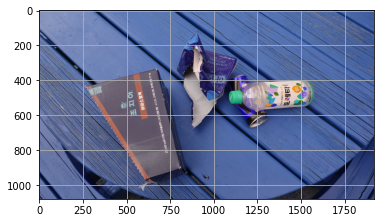

In [ ]:
plt.grid(True)
plt.imshow(img_0)#.clip(0, 255).astype('uint8'))

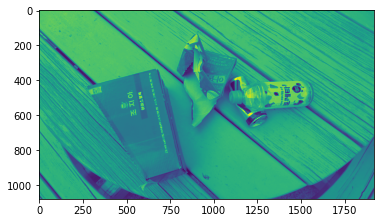

In [ ]:
plt.imshow(img_0[...,2])

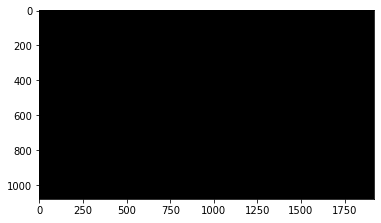

In [ ]:
mask = np.full(img_0.shape, 0, dtype=np.uint8)
plt.imshow(mask)

# and, not, or, xor
cv.bitwise_or()

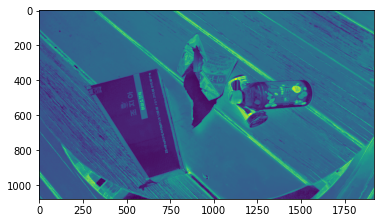

In [ ]:
# COLOR_BGR2HLS_FULL <- 보류
# COLOR_BGR2RGB -> drop
# COLOR_BGR2HLS -> drop
plt.imshow(cv.cvtColor(img_0, cv.COLOR_BGR2HLS_FULL)[...,2])

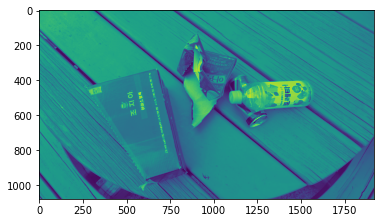

In [ ]:
plt.imshow(cv.cvtColor(img_0, cv.COLOR_BGR2Luv)[...,0])

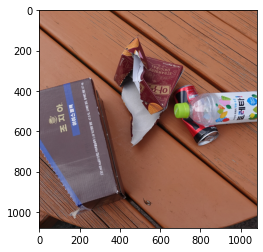

In [ ]:
cv_imshow(img_0[0:1080, 420:1920-420])

In [ ]:
 img_0[0:1080, 420:1920-420].shape

(1080, 1080, 3)

pre-train은 어떤 데이터를 사용할 것인가.

annotation이 있어야 하는데 없음, 하...하나씩 값을 확인 후 따야 함.

cv2에 new extension을 추가하려면, C를 사용해야하는데, colab 매직명령어에 javascript는 있고, c는 없는 것으로 보면, sh로 사용해야 할 듯

일단 제공된 이미지의 shape은 (1080, 1920, 3)으로 동일함.

모서리에 쏠린 데이터는 없다는 것이 다행임.

<h3>Grid_plt_for_annotation</h3>
보통 이미지는 height, width가 2의 배수임. 일반적으로 grid 나눠서 작업할 때, 100by100이었던 것을 떠올리면, grid 간격이 100이어도 될 것 같은데,

* 1020*1980
* 128 > 256 > 512 > 1024
* 32 > 64 > 128 > 256
* 8 > 16 > 32 > 64

```python
plt_opt = {"c_opt" : ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w'],
           "l_opt" : ['-', '--', '-.', ':', None, 'solid', 'dashed', 'dashdot', 'dotted'],
           "grid_range" : ?,
           "grid_opt" : ?,
           "ax_HW" : (,),
           "ax_RC" : (,)}
```

상하-100을 하게 되면, 30개의 데이터 중 3개는 설명력을 잃어버릴 위험이 있음. 좌우 -420을 하게 되면, 30개 데이터 중 1개의 설명력을 소폭 잃을 위험이 있으나, 해당 데이터 내 박스가 차지하는 면적이 넓기 때문에 1080*1080으로 자른 뒤, 시도하는 것도 의미가 있을 것으로 사료됨.

중심을 기준으로 crop하는 방법, FPN, 혹은 포인트 지점을 잡고 zoom-in, out을 하는 방법은 없는지에 대한 연구가 필요함.

투명한 재질은 굴곡이나 반사된 부분을 인지할 수 있는지 혹은 인지하게끔 할 방법이 있는지에 대해서도 연구가 필요함.


In [7]:
class CV_Basic:
    """
    .JPG를 .jpg로 입력하면 glob, cv2가 인식을 못함
    """
    def __init__(self, path, add_path=None, extension_type="jpg", new_path=None):
        self.path = path
        self.img_paths = sorted(gb(self.path + f'/{add_path}/*.{extension_type}'))
        if self.img_paths == []:
            self.img_paths = sorted(gb(self.path + f'/*.{extension_type}'))
        self.imgs = self.cv_imread()
        self.new_path = new_path

    def cv_imread(self):
        # center를 기준으로 좌우 crop => (30, 1080, 1080, 3)
            # case 1, image shape이 다른 경우 ? -> resize
            # case 2, 
        # tensor -> [height, width, color_BGR] -> [height, width, color_RGB] => (stack?append?) => [batch_size, height, width, color_RGB] : (30, 1080, 1920, 3)
        img_list = []
        for path in self.img_paths:
            img = cv.imread(path)
            img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
            img = torch.FloatTensor(img / 255.)
            img_list.append(img)
        self.imgs = torch.stack(img_list)
        return self.imgs

    def cv_imshow(self):
        a = a.clip(0, 255).astype('uint8')
        # cv2 stores colors as BGR; convert to RGB
        # 색상 전환 전후가 다르게 들어가야 함
        if a.ndim == 3:
            if a.shape[2] == 4:
                a = cv.cvtColor(a, cv.COLOR_BGRA2RGBA)
            else:
                a = cv.cvtColor(a, cv.COLOR_BGR2RGB)
        return plt.imshow(a, **kwargs)

    def cv_imsave(self, save_img, save_img_name):
        # 분류별로 tensor로 만든 뒤, 저장을 해야할 지, 각 이미지별로 저장할...우선 그냥 저장
        try:
            os.makedirs(os.path.join(self.path, self.new_path))
            print(f"Created {self.new_path} Dir!\n")
        except:
            print(f"Exist {self.new_path} Dir!\n")
        save_path = os.path.join(self.path, self.new_path)
        cv.imwrite(f"{save_path}/{save_img_name}.jpg", save_img)

class CV_annoation(CV_Basic):
    """
    컬러 채녈별, 사이즈별 
    """
    def __init__(self, path, add_path=None, extension_type="jpg", new_path=None):
        super(CV_Transform).__init__(self, path, add_path=None, extension_type="jpg")


class CV_Transform(CV_Basic):
    def __init__(self, path, add_path=None, extension_type="jpg", new_path=None):
        super(CV_Transform).__init__(self, path, add_path=None, extension_type="jpg

In [ ]:
init_img = CV_Basic(path, "train", "JPG")

In [ ]:
images = init_img.cv_imread()

In [ ]:
c_opt = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']
l_opt = ['-', '--', '-.', ':', 'solid', 'dashed', 'dashdot', 'dotted']

for num in range(30):
    print(f'Image number : {num}')
    plt.grid(color=c_opt[-1], linestyle=l_opt[-2], linewidth=1)
    plt.imshow(images[num])
    plt.show()

출력되는 내용을 확인했고, annotation 등은 다른 파일에서 진행함. 추후 함수가 달라질 수도 있음

# YOLO


yolo_cogs = {"ver_info" : ["v1", "v2", "v3"],
             "arch_info" : []}

```
YOLOv1
architecture_config = [
    # Tuple : (kernel_size, num_filters, stride, padding)
    # List : tuples and then last integer represents number of repeats
    (7, 64, 2, 3),
    "M",

    (3, 192, 1, 1),
    "M",

    (1, 128, 1, 0),
    (3, 256, 1, 1),
    (3, 256, 1, 0),
    (3, 512, 1, 1),
    "M",

    # Fully Connected Layer
    [(1, 256, 1, 0), (3, 512, 1, 1), 4],
    (1, 512, 1, 0),
    (3, 1024, 1, 1),
    "M",

    # Fully Connected Layer
    [(1, 512, 1, 0), (3, 1024, 1, 1), 2],
    (3, 1024, 1, 1),
    (3, 1024, 2, 1),
    
    (3, 1024, 1, 1),
    (3, 1024, 1, 1),
]
```

```
YOLOv3
architecture_config = [
    # Tuple : (kernel_size, num_filters, stride, padding)
    # List : tuples and then last integer represents number of repeats
    # List : Scale for detecting small/medium/large objects
    (7, 64, 2, 3),
    "M",

    (3, 192, 1, 1),
    "M",

    (1, 128, 1, 0),
    (3, 256, 1, 1),
    (3, 256, 1, 0),
    (3, 512, 1, 1),
    "M",

    # Fully Connected Layer
    [(1, 256, 1, 0), (3, 512, 1, 1), 4],
    (1, 512, 1, 0),
    (3, 1024, 1, 1),
    "M",

    # Fully Connected Layer
    [(1, 512, 1, 0), (3, 1024, 1, 1), 2],
    (3, 1024, 1, 1),
    (3, 1024, 2, 1),
    
    (3, 1024, 1, 1),
    (3, 1024, 1, 1),
]
```

* Backbone
  - img0 -> x1/(2**0)
  - img1 -> x1/(2**1)
  - img2 -> x1/(2**2)
  - img3 -> x1/(2**3)   # : shortcut0
  - img4 -> x1/(2**4)   # : shortcut1
  - img5 -> x1/(2**5)
* Neck
  - img6 -> x1/(2**5)
  - img7 -> x1/(2**4)   # : shortcut0
  - img8 -> x1/(2**3)   # : shortcut1
* YOLO Layers _ 
grid_cell_params = [x,y,w,h,obj,cls0,...,cls(n-1)]
  - smobj
  - mdobj
  - lgobj

alexnet, resnet, vgg를 활용하는 거라면, mmcv를 사용해도 됨. 물론 같은 이유에서 mmdet를 사용해도 됨.

mm~ 시리즈를 활용하는 것이 나은가? 우선 가볍게 논문따라 darknet이 나은가...?

다른 분께 설명이 쉬우려면, 그냥 논문따라 작성하는게 나은듯
아니다...그냥 깃헙에 따라가라고 하는게 나은가?
그냥 단순 구현인 깃헙 folk가 쉬운데, 근데 결국 대회 제출을 위해서 작성하려면,,,,,,,,,,,,,,,,,,,,,깃헙project를 보면서 접근 구조를 설명하거나, 처음부터 작성하는 걸 보여야할텐데,,,ㅎㅎ...나는 아무 생각이 없다 아무 생각이 없기 때문이다.....아몰라

<h3>generate 시, 활용하기 좋은 torch basic</h3>

* (img_tensor_name).unsqueeze()
* torch.cat()
* torch.stack()

<h3>labeling할 때가 될 지,,,cls별 wieghts를 저장할 때가 될 지 모르겠지만 무튼 활용하기 좋아보임</h3>

* torch.split()
* torch.chuck()
* torch.tensor_split()

아무리 봐도,,, YOLOv3의 architecture가 input_shape별로 다르게 구성이 되어 있는데,,,

init이...몇 백 줄 이상인 경우도 있음..하

assert, @property 데코레이터도 활용해야 하는지는...익숙하지 않은데...

중국애들이 yolo 관련 정리한 내용도 있는데, 이슈 follow-up하면, 대략적인 문제 발생 지점 체크도 가능할 것으로 보임.

대충 봤을 때, 모형("모의"로 해석함이 더 매끄러운 듯)훈련과정 중 평가 문제 발생(loss_fuction이나 evaluation의 문제를 말하는 듯)

[模型训练过程中评估报错](https://github.com/PaddlePaddle/PaddleX/issues/685)
(thomas)

## darknet(tinyYOLO) 

1. 구글 드라이브 접근
2. gdrive -> {project_dirs}
3. makedir ~/{project_dirs}/cudnn
    * install cudnn(ver11.1.1)
    * 
    ```bash
    !tar -xzvf ~/{project_dirs}/cudnn/cudnn-11.1-linux-x64-v7.5.0.56.solitairetheme8 -C /usr/local/
    /*상세 version은 다를 수 있음_cudnn 설치 내역 확인 후 명령어 수정할 것*/
    ```
4. clone darknet -> shutil.copytree("/content/darknet","~/{project_dirs}/bin/darknet") or !cp ./darknet ~/{project_dirs}/bin/darknet
5. GPU=1 CUDNN=1 CUDNN_HALF=1 OPENCV=1 AVX=0 OPENMP=0 LIBSO=1
6. !chmod +x ./darknet

In [ ]:
!git clone https://github.com/pjreddie/darknet.git
%cd darknet
!make

/content/darknet
mkdir -p obj
mkdir -p backup
mkdir -p results
gcc -Iinclude/ -Isrc/ -Wall -Wno-unused-result -Wno-unknown-pragmas -Wfatal-errors -fPIC -Ofast -c ./src/gemm.c -o obj/gemm.o
gcc -Iinclude/ -Isrc/ -Wall -Wno-unused-result -Wno-unknown-pragmas -Wfatal-errors -fPIC -Ofast -c ./src/utils.c -o obj/utils.o
gcc -Iinclude/ -Isrc/ -Wall -Wno-unused-result -Wno-unknown-pragmas -Wfatal-errors -fPIC -Ofast -c ./src/cuda.c -o obj/cuda.o
gcc -Iinclude/ -Isrc/ -Wall -Wno-unused-result -Wno-unknown-pragmas -Wfatal-errors -fPIC -Ofast -c ./src/deconvolutional_layer.c -o obj/deconvolutional_layer.o
gcc -Iinclude/ -Isrc/ -Wall -Wno-unused-result -Wno-unknown-pragmas -Wfatal-errors -fPIC -Ofast -c ./src/convolutional_layer.c -o obj/convolutional_layer.o
gcc -Iinclude/ -Isrc/ -Wall -Wno-unused-result -Wno-unknown-pragmas -Wfatal-errors -fPIC -Ofast -c ./src/list.c -o obj/list.o
gcc -Iinclude/ -Isrc/ -Wall -Wno-unused-result -Wno-unknown-pragmas -Wfatal-errors -fPIC -Ofast -c ./src/image.c -o

In [ ]:
!ls

backup	 examples	LICENSE       LICENSE.meta  obj        scripts
cfg	 include	LICENSE.fuck  LICENSE.mit   python     src
darknet  libdarknet.a	LICENSE.gen   LICENSE.v1    README.md
data	 libdarknet.so	LICENSE.gpl   Makefile	    results


In [ ]:
!./darknet

usage: ./darknet <function>


In [ ]:
!ls

backup	 examples	LICENSE       LICENSE.meta  obj        scripts
cfg	 include	LICENSE.fuck  LICENSE.mit   python     src
darknet  libdarknet.a	LICENSE.gen   LICENSE.v1    README.md
data	 libdarknet.so	LICENSE.gpl   Makefile	    results


In [ ]:
%%shell
GPU=1
# GPU-based
./darknet -i 1 imagenet test cfg/alexnet.cfg alexnet.weights

# CPU-based
./darknet -nogpu imagenet test cfg/alexnet.cfg alexnet.weights

# CV
OPENCV=1
./darknet imtest data/eagle.jpg

Not an option: imagenet


In [ ]:
%%bash
cat Makefile "GPU=0" >> Makefile "GPU=1"
cat Makefile

GPU=0
CUDNN=0
OPENCV=0
OPENMP=0
DEBUG=0

ARCH= -gencode arch=compute_30,code=sm_30 \
      -gencode arch=compute_35,code=sm_35 \
      -gencode arch=compute_50,code=[sm_50,compute_50] \
      -gencode arch=compute_52,code=[sm_52,compute_52]
#      -gencode arch=compute_20,code=[sm_20,sm_21] \ This one is deprecated?

# This is what I use, uncomment if you know your arch and want to specify
# ARCH= -gencode arch=compute_52,code=compute_52

VPATH=./src/:./examples
SLIB=libdarknet.so
ALIB=libdarknet.a
EXEC=darknet
OBJDIR=./obj/

CC=gcc
CPP=g++
NVCC=nvcc 
AR=ar
ARFLAGS=rcs
OPTS=-Ofast
LDFLAGS= -lm -pthread 
COMMON= -Iinclude/ -Isrc/
CFLAGS=-Wall -Wno-unused-result -Wno-unknown-pragmas -Wfatal-errors -fPIC

ifeq ($(OPENMP), 1) 
CFLAGS+= -fopenmp
endif

ifeq ($(DEBUG), 1) 
OPTS=-O0 -g
endif

CFLAGS+=$(OPTS)

ifeq ($(OPENCV), 1) 
COMMON+= -DOPENCV
CFLAGS+= -DOPENCV
LDFLAGS+= `pkg-config --libs opencv` -lstdc++
COMMON+= `pkg-config --cflags opencv` 
endif

ifeq ($(GPU), 1) 
COMMON+= -DGPU -I/u

cat: Makefile: input file is output file
cat: 'GPU=0': No such file or directory
cat: 'GPU=1': No such file or directory


In [ ]:
!ls ./cfg

alexnet.cfg	     imagenet1k.data		   vgg-16.cfg
cifar.cfg	     imagenet22k.dataset	   vgg-conv.cfg
cifar.test.cfg	     imagenet9k.hierarchy.dataset  voc.data
coco.data	     jnet-conv.cfg		   writing.cfg
combine9k.data	     openimages.data		   yolo9000.cfg
darknet19_448.cfg    resnet101.cfg		   yolov1.cfg
darknet19.cfg	     resnet152.cfg		   yolov1-tiny.cfg
darknet53_448.cfg    resnet18.cfg		   yolov2.cfg
darknet53.cfg	     resnet34.cfg		   yolov2-tiny.cfg
darknet9000.cfg      resnet50.cfg		   yolov2-tiny-voc.cfg
darknet.cfg	     resnext101-32x4d.cfg	   yolov2-voc.cfg
densenet201.cfg      resnext152-32x4d.cfg	   yolov3.cfg
extraction22k.cfg    resnext50.cfg		   yolov3-openimages.cfg
extraction.cfg	     rnn.cfg			   yolov3-spp.cfg
extraction.conv.cfg  rnn.train.cfg		   yolov3-tiny.cfg
go.cfg		     strided.cfg		   yolov3-voc.cfg
go.test.cfg	     t1.test.cfg
gru.cfg		     tiny.cfg


<table>
<th>yolov1-tiny</th>
<th>yolov1</th>
<th>yolov3-tiny</th>
<th>yolov3</th>

<tr>
<p><td>
[net]</br>
# Testing</br>
batch=1</br>
subdivisions=1</br>
# Training</br>
# batch=64</br>
# subdivisions=8</br>
height=448</br>
width=448</br>
channels=3</br>
momentum=0.9</br>
decay=0.0005</br>
''''''</br>
saturation=.75</br>
exposure=.75</br>
hue = .1</br>
''''''</br>
learning_rate=0.0005</br>
policy=steps</br>
steps=200,400,600,800,20000,30000</br>
scales=2.5,2,2,2,.1,.1</br>
max_batches = 40000</br>
''''''</br>
[convolutional]</br>
batch_normalize=1</br>
filters=16</br>
size=3</br>
stride=1</br>
pad=1</br>
activation=leaky</br>
''''''</br>
[maxpool]</br>
size=2</br>
stride=2</br>
''''''</br>
[convolutional]</br>
batch_normalize=1</br>
filters=32</br>
size=3</br>
stride=1</br>
pad=1</br>
activation=leaky</br>
''''''</br>
[maxpool]</br>
size=2</br>
stride=2</br>
''''''</br>
[convolutional]</br>
batch_normalize=1</br>
filters=64</br>
size=3</br>
stride=1</br>
pad=1</br>
activation=leaky</br>
''''''</br>
[maxpool]</br>
size=2</br>
stride=2</br>
'''''''</br>
[convolutional]</br>
batch_normalize=1</br>
filters=128</br>
size=3</br>
stride=1</br>
pad=1</br>
activation=leaky</br>
''''''</br>
[maxpool]</br>
size=2</br>
stride=2</br>
''''''</br>
[convolutional]</br>
batch_normalize=1</br>
filters=256</br>
size=3</br>
stride=1</br>
pad=1</br>
activation=leaky</br>
''''''</br>
[maxpool]</br>
size=2</br>
stride=2</br>
''''''</br>
[convolutional]</br>
batch_normalize=1</br>
filters=512</br>
size=3</br>
stride=1</br>
pad=1</br>
activation=leaky</br>
''''''</br>
[maxpool]</br>
size=2</br>
stride=2</br>
''''''
[convolutional]</br>
batch_normalize=1</br>
size=3</br>
stride=1</br>
pad=1</br>
filters=1024</br>
activation=leaky</br>
''''''</br>
[convolutional]</br>
batch_normalize=1</br>
size=3</br>
stride=1</br>
pad=1</br>
filters=256</br>
activation=leaky</br>
''''''</br>
[connected]</br>
output= 1470</br>
activation=linear</br>
''''''</br>
[detection]</br>
classes=20</br>
coords=4</br>
rescore=1</br>
side=7</br>
num=2</br>
softmax=0</br>
sqrt=1</br>
jitter=.2</br>
''''''</br>
object_scale=1</br>
noobject_scale=.5</br>
class_scale=1</br>
coord_scale=5</td></p>

<p><td>
[net]</br>
# Testing</br>
batch=1</br>
subdivisions=1</br>
# Training</br>
# batch=64</br>
# subdivisions=8</br>
height=448</br>
width=448</br>
channels=3</br>
momentum=0.9</br>
decay=0.0005</br>
saturation=1.5</br>
exposure=1.5</br>
hue=.1</br>
''''''</br>
learning_rate=0.0005</br>
policy=steps</br>
steps=200,400,600,20000,30000</br>
scales=2.5,2,2,.1,.1</br>
max_batches = 40000</br>
''''''</br>
[convolutional]</br>
batch_normalize=1</br>
filters=64</br>
size=7</br>
stride=2</br>
pad=1</br>
activation=leaky</br>
''''''</br>
[maxpool]</br>
size=2</br>
stride=2</br>
''''''</br>
[convolutional]</br>
batch_normalize=1</br>
filters=192</br>
size=3</br>
stride=1</br>
pad=1</br>
activation=leaky</br>
''''''</br>
[maxpool]</br>
size=2</br>
stride=2</br>
''''''</br>
[convolutional]</br>
batch_normalize=1</br>
filters=128</br>
size=1</br>
stride=1</br>
pad=1</br>
activation=leaky</br>
''''''</br>
[convolutional]</br>
batch_normalize=1</br>
filters=256</br>
size=3</br>
stride=1</br>
pad=1</br>
activation=leaky</br>
''''''</br>
[convolutional]</br>
batch_normalize=1</br>
filters=256</br>
size=1</br>
stride=1</br>
pad=1</br>
activation=leaky</br>
''''''</br>
[convolutional]</br>
batch_normalize=1</br>
filters=512</br>
size=3</br>
stride=1</br>
pad=1</br>
activation=leaky</br>
''''''</br>
[maxpool]</br>
size=2</br>
stride=2</br>
''''''</br>
[convolutional]</br>
batch_normalize=1</br>
filters=256</br>
size=1</br>
stride=1</br>
pad=1</br>
activation=leaky</br>
''''''</br>
[convolutional]</br>
batch_normalize=1</br>
filters=512</br>
size=3</br>
stride=1</br>
pad=1</br>
activation=leaky</br>
''''''</br>
[convolutional]</br>
batch_normalize=1</br>
filters=256</br>
size=1</br>
stride=1</br>
pad=1</br>
activation=leaky</br>
''''''</br>
[convolutional]</br>
batch_normalize=1</br>
filters=512</br>
size=3</br>
stride=1</br>
pad=1</br>
activation=leaky</br>
''''''</br>
[convolutional]</br>
batch_normalize=1</br>
filters=256</br>
size=1</br>
stride=1</br>
pad=1</br>
activation=leaky</br>
''''''</br>
[convolutional]</br>
batch_normalize=1</br>
filters=512</br>
size=3</br>
stride=1</br>
pad=1</br>
activation=leaky</br>
''''''</br>
[convolutional]</br>
batch_normalize=1</br>
filters=256</br>
size=1</br>
stride=1</br>
pad=1</br>
activation=leaky</br>
''''''</br>
[convolutional]</br>
batch_normalize=1</br>
filters=512</br>
size=3</br>
stride=1</br>
pad=1</br>
activation=leaky</br>
''''''</br>
[convolutional]</br>
batch_normalize=1</br>
filters=512</br>
size=1</br>
stride=1</br>
pad=1</br>
activation=leaky</br>
''''''</br>
[convolutional]</br>
batch_normalize=1</br>
filters=1024</br>
size=3</br>
stride=1</br>
pad=1</br>
activation=leaky</br>
''''''</br>
[maxpool]</br>
size=2</br>
stride=2</br>
''''''</br>
[convolutional]</br>
batch_normalize=1</br>
filters=512</br>
size=1</br>
stride=1</br>
pad=1</br>
activation=leaky</br>
''''''</br>
[convolutional]</br>
batch_normalize=1</br>
filters=1024</br>
size=3</br>
stride=1</br>
pad=1</br>
activation=leaky</br>
''''''</br>
[convolutional]</br>
batch_normalize=1</br>
filters=512</br>
size=1</br>
stride=1</br>
pad=1</br>
activation=leaky</br>
''''''</br>
[convolutional]</br>
batch_normalize=1</br>
filters=1024</br>
size=3</br>
stride=1</br>
pad=1</br>
activation=leaky</br>
''''''</br>
#######</br>
''''''</br>
[convolutional]</br>
batch_normalize=1</br>
size=3</br>
stride=1</br>
pad=1</br>
filters=1024</br>
activation=leaky</br>
''''''</br>
[convolutional]</br>
batch_normalize=1</br>
size=3</br>
stride=2</br>
pad=1</br>
filters=1024</br>
activation=leaky</br>
''''''</br>
[convolutional]</br>
batch_normalize=1</br>
size=3</br>
stride=1</br>
pad=1</br>
filters=1024</br>
activation=leaky</br>
''''''</br>
[convolutional]</br>
batch_normalize=1</br>
size=3</br>
stride=1</br>
pad=1</br>
filters=1024</br>
activation=leaky</br>
''''''</br>
[local]</br>
size=3</br>
stride=1</br>
pad=1</br>
filters=256</br>
activation=leaky</br>
''''''</br>
[dropout]</br>
probability=.5</br>
''''''</br>
[connected]</br>
output= 1715</br>
activation=linear</br>
''''''</br>
[detection]</br>
classes=20</br>
coords=4</br>
rescore=1</br>
side=7</br>
num=3</br>
softmax=0</br>
sqrt=1</br>
jitter=.2</br>
''''''</br>
object_scale=1</br>
noobject_scale=.5</br>
class_scale=1</br>
coord_scale=5</td></p>

<p><td>[net]</br>
# Testing</br>
batch=1</br>
subdivisions=1</br>
# Training</br>
# batch=64</br>
# subdivisions=2</br>
width=416</br>
height=416</br>
channels=3</br>
momentum=0.9</br>
decay=0.0005</br>
angle=0</br>
saturation = 1.5</br>
exposure = 1.5</br>
hue=.1</br>
</br>
learning_rate=0.001</br>
burn_in=1000</br>
max_batches = 500200</br>
policy=steps</br>
steps=400000,450000</br>
scales=.1,.1</br>
</br>
[convolutional]</br>
batch_normalize=1</br>
filters=16</br>
size=3</br>
stride=1</br>
pad=1</br>
activation=leaky</br>
</br>
[maxpool]</br>
size=2</br>
stride=2</br>
</br>
[convolutional]</br>
batch_normalize=1</br>
filters=32</br>
size=3</br>
stride=1</br>
pad=1</br>
activation=leaky</br>
</br>
[maxpool]</br>
size=2</br>
stride=2</br>
</br>
[convolutional]</br>
batch_normalize=1</br>
filters=64</br>
size=3</br>
stride=1</br>
pad=1</br>
activation=leaky</br>
</br>
[maxpool]</br>
size=2</br>
stride=2</br>
</br>
[convolutional]</br>
batch_normalize=1</br>
filters=128</br>
size=3</br>
stride=1</br>
pad=1</br>
activation=leaky</br>
</br>
[maxpool]</br>
size=2</br>
stride=2</br>
</br>
[convolutional]</br>
batch_normalize=1</br>
filters=256</br>
size=3</br>
stride=1</br>
pad=1</br>
activation=leaky</br>
</br>
[maxpool]</br>
size=2</br>
stride=2</br>
</br>
[convolutional]</br>
batch_normalize=1</br>
filters=512</br>
size=3</br>
stride=1</br>
pad=1</br>
activation=leaky</br>
</br>
[maxpool]</br>
size=2</br>
stride=1</br>
</br>
[convolutional]</br>
batch_normalize=1</br>
filters=1024</br>
size=3</br>
stride=1</br>
pad=1</br>
activation=leaky</br>
</br>
###########</br>
</br>
[convolutional]</br>
batch_normalize=1</br>
filters=256</br>
size=1</br>
stride=1</br>
pad=1</br>
activation=leaky</br>
</br>
[convolutional]</br>
batch_normalize=1</br>
filters=512</br>
size=3</br>
stride=1</br>
pad=1</br>
activation=leaky</br>
</br>
[convolutional]</br>
size=1</br>
stride=1</br>
pad=1</br>
filters=255</br>
activation=linear</br>
</br>
</br>
</br>
[yolo]</br>
mask = 3,4,5</br>
anchors = 10,14,  23,27,  37,58,  81,82,  135,169,  344,319</br>
classes=80</br>
num=6</br>
jitter=.3</br>
ignore_thresh = .7</br>
truth_thresh = 1</br>
random=1</br>
</br>
[route]</br>
layers = -4</br>
</br>
[convolutional]</br>
batch_normalize=1</br>
filters=128</br>
size=1</br>
stride=1</br>
pad=1</br>
activation=leaky</br>
</br>
[upsample]</br>
stride=2</br>
</br>
[route]</br>
layers = -1, 8</br>
</br>
[convolutional]</br>
batch_normalize=1</br>
filters=256</br>
size=3</br>
stride=1</br>
pad=1</br>
activation=leaky</br>
</br>
[convolutional]</br>
size=1</br>
stride=1</br>
pad=1</br>
filters=255</br>
activation=linear</br>
</br>
[yolo]</br>
mask = 0,1,2</br>
anchors = 10,14,  23,27,  37,58,  81,82,  135,169,  344,319</br>
classes=80</br>
num=6</br>
jitter=.3</br>
ignore_thresh = .7</br>
truth_thresh = 1</br>
random=1</td></p>

<p><td>[net]</br>
# Testing</br>
# batch=1</br>
# subdivisions=1</br>
# Training</br>
batch=64</br>
subdivisions=16</br>
width=608</br>
height=608</br>
channels=3</br>
momentum=0.9</br>
decay=0.0005</br>
angle=0</br>
saturation = 1.5</br>
exposure = 1.5</br>
hue=.1</br>
</br>
learning_rate=0.001</br>
burn_in=1000</br>
max_batches = 500200</br>
policy=steps</br>
steps=400000,450000</br>
scales=.1,.1</br>
</br>
[convolutional]</br>
batch_normalize=1</br>
filters=32</br>
size=3</br>
stride=1</br>
pad=1</br>
activation=leaky</br>
</br>
# Downsample</br>
</br>
[convolutional]</br>
batch_normalize=1</br>
filters=64</br>
size=3</br>
stride=2</br>
pad=1</br>
activation=leaky</br>
</br>
[convolutional]</br>
batch_normalize=1</br>
filters=32</br>
size=1</br>
stride=1</br>
pad=1</br>
activation=leaky</br>
</br>
[convolutional]</br>
batch_normalize=1</br>
filters=64</br>
size=3</br>
stride=1</br>
pad=1</br>
activation=leaky</br>
</br>
[shortcut]</br>
from=-3</br>
activation=linear</br>
</br>
# Downsample</br>
</br>
[convolutional]</br>
batch_normalize=1</br>
filters=128</br>
size=3</br>
stride=2</br>
pad=1</br>
activation=leaky</br>
</br>
[convolutional]</br>
batch_normalize=1</br>
filters=64</br>
size=1</br>
stride=1</br>
pad=1</br>
activation=leaky</br>
</br>
[convolutional]</br>
batch_normalize=1</br>
filters=128</br>
size=3</br>
stride=1</br>
pad=1</br>
activation=leaky</br>
</br>
[shortcut]</br>
from=-3</br>
activation=linear</br>
</br>
[convolutional]</br>
batch_normalize=1</br>
filters=64</br>
size=1</br>
stride=1</br>
pad=1</br>
activation=leaky</br>
</br>
[convolutional]</br>
batch_normalize=1</br>
filters=128</br>
size=3</br>
stride=1</br>
pad=1</br>
activation=leaky</br>
</br>
[shortcut]</br>
from=-3</br>
activation=linear</br>
</br>
# Downsample</br>
</br>
[convolutional]</br>
batch_normalize=1</br>
filters=256</br>
size=3</br>
stride=2</br>
pad=1</br>
activation=leaky</br>
</br>
[convolutional]</br>
batch_normalize=1</br>
filters=128</br>
size=1</br>
stride=1</br>
pad=1</br>
activation=leaky</br>
</br>
[convolutional]</br>
batch_normalize=1</br>
filters=256</br>
size=3</br>
stride=1</br>
pad=1</br>
activation=leaky</br>
</br>
[shortcut]</br>
from=-3</br>
activation=linear</br>
</br>
[convolutional]</br>
batch_normalize=1</br>
filters=128</br>
size=1</br>
stride=1</br>
pad=1</br>
activation=leaky</br>
</br>
[convolutional]</br>
batch_normalize=1</br>
filters=256</br>
size=3</br>
stride=1</br>
pad=1</br>
activation=leaky</br>
</br>
[shortcut]</br>
from=-3</br>
activation=linear</br>
</br>
[convolutional]</br>
batch_normalize=1</br>
filters=128</br>
size=1</br>
stride=1</br>
pad=1</br>
activation=leaky</br>
</br>
[convolutional]</br>
batch_normalize=1</br>
filters=256</br>
size=3</br>
stride=1</br>
pad=1</br>
activation=leaky</br>
</br>
[shortcut]</br>
from=-3</br>
activation=linear</br>
</br>
[convolutional]</br>
batch_normalize=1</br>
filters=128</br>
size=1</br>
stride=1</br>
pad=1</br>
activation=leaky</br>
</br>
[convolutional]</br>
batch_normalize=1</br>
filters=256</br>
size=3</br>
stride=1</br>
pad=1</br>
activation=leaky</br>
</br>
[shortcut]</br>
from=-3</br>
activation=linear</br>
</br>
</br>
[convolutional]</br>
batch_normalize=1</br>
filters=128</br>
size=1</br>
stride=1</br>
pad=1</br>
activation=leaky</br>
</br>
[convolutional]</br>
batch_normalize=1</br>
filters=256</br>
size=3</br>
stride=1</br>
pad=1</br>
activation=leaky</br>
</br>
[shortcut]</br>
from=-3</br>
activation=linear</br>
</br>
[convolutional]</br>
batch_normalize=1</br>
filters=128</br>
size=1</br>
stride=1</br>
pad=1</br>
activation=leaky</br>
</br>
[convolutional]</br>
batch_normalize=1</br>
filters=256</br>
size=3</br>
stride=1</br>
pad=1</br>
activation=leaky</br>
</br>
[shortcut]</br>
from=-3</br>
activation=linear</br>
</br>
[convolutional]</br>
batch_normalize=1</br>
filters=128</br>
size=1</br>
stride=1</br>
pad=1</br>
activation=leaky</br>
</br>
[convolutional]</br>
batch_normalize=1</br>
filters=256</br>
size=3</br>
stride=1</br>
pad=1</br>
activation=leaky</br>
</br>
[shortcut]</br>
from=-3</br>
activation=linear</br>
</br>
[convolutional]</br>
batch_normalize=1</br>
filters=128</br>
size=1</br>
stride=1</br>
pad=1</br>
activation=leaky</br>
</br>
[convolutional]</br>
batch_normalize=1</br>
filters=256</br>
size=3</br>
stride=1</br>
pad=1</br>
activation=leaky</br>
</br>
[shortcut]</br>
from=-3</br>
activation=linear</br>
</br>
# Downsample</br>
</br>
[convolutional]</br>
batch_normalize=1</br>
filters=512</br>
size=3</br>
stride=2</br>
pad=1</br>
activation=leaky</br>
</br>
[convolutional]</br>
batch_normalize=1</br>
filters=256</br>
size=1</br>
stride=1</br>
pad=1</br>
activation=leaky</br>
</br>
[convolutional]</br>
batch_normalize=1</br>
filters=512</br>
size=3</br>
stride=1</br>
pad=1</br>
activation=leaky</br>
</br>
[shortcut]</br>
from=-3</br>
activation=linear</br>
</br>
</br>
[convolutional]</br>
batch_normalize=1</br>
filters=256</br>
size=1</br>
stride=1</br>
pad=1</br>
activation=leaky</br>
</br>
[convolutional]</br>
batch_normalize=1</br>
filters=512</br>
size=3</br>
stride=1</br>
pad=1</br>
activation=leaky</br>
</br>
[shortcut]</br>
from=-3</br>
activation=linear</br>
</br>
</br>
[convolutional]</br>
batch_normalize=1</br>
filters=256</br>
size=1</br>
stride=1</br>
pad=1</br>
activation=leaky</br>
</br>
[convolutional]</br>
batch_normalize=1</br>
filters=512</br>
size=3</br>
stride=1</br>
pad=1</br>
activation=leaky</br>
</br>
[shortcut]</br>
from=-3</br>
activation=linear</br>
</br>
</br>
[convolutional]</br>
batch_normalize=1</br>
filters=256</br>
size=1</br>
stride=1</br>
pad=1</br>
activation=leaky</br>
</br>
[convolutional]</br>
batch_normalize=1</br>
filters=512</br>
size=3</br>
stride=1</br>
pad=1</br>
activation=leaky</br>
</br>
[shortcut]</br>
from=-3</br>
activation=linear</br>
</br>
[convolutional]</br>
batch_normalize=1</br>
filters=256</br>
size=1</br>
stride=1</br>
pad=1</br>
activation=leaky</br>
</br>
[convolutional]</br>
batch_normalize=1</br>
filters=512</br>
size=3</br>
stride=1</br>
pad=1</br>
activation=leaky</br>
</br>
[shortcut]</br>
from=-3</br>
activation=linear</br>
</br>
</br>
[convolutional]</br>
batch_normalize=1</br>
filters=256</br>
size=1</br>
stride=1</br>
pad=1</br>
activation=leaky</br>
</br>
[convolutional]</br>
batch_normalize=1</br>
filters=512</br>
size=3</br>
stride=1</br>
pad=1</br>
activation=leaky</br>
</br>
[shortcut]</br>
from=-3</br>
activation=linear</br>
</br>
</br>
[convolutional]</br>
batch_normalize=1</br>
filters=256</br>
size=1</br>
stride=1</br>
pad=1</br>
activation=leaky</br>
</br>
[convolutional]</br>
batch_normalize=1</br>
filters=512</br>
size=3</br>
stride=1</br>
pad=1</br>
activation=leaky</br>
</br>
[shortcut]</br>
from=-3</br>
activation=linear</br>
</br>
[convolutional]</br>
batch_normalize=1</br>
filters=256</br>
size=1</br>
stride=1</br>
pad=1</br>
activation=leaky</br>
</br>
[convolutional]</br>
batch_normalize=1</br>
filters=512</br>
size=3</br>
stride=1</br>
pad=1</br>
activation=leaky</br>
</br>
[shortcut]</br>
from=-3</br>
activation=linear</br>
</br>
# Downsample</br>
</br>
[convolutional]</br>
batch_normalize=1</br>
filters=1024</br>
size=3</br>
stride=2</br>
pad=1</br>
activation=leaky</br>
</br>
[convolutional]</br>
batch_normalize=1</br>
filters=512</br>
size=1</br>
stride=1</br>
pad=1</br>
activation=leaky</br>
</br>
[convolutional]</br>
batch_normalize=1</br>
filters=1024</br>
size=3</br>
stride=1</br>
pad=1</br>
activation=leaky</br>
</br>
[shortcut]</br>
from=-3</br>
activation=linear</br>
</br>
[convolutional]</br>
batch_normalize=1</br>
filters=512</br>
size=1</br>
stride=1</br>
pad=1</br>
activation=leaky</br>
</br>
[convolutional]</br>
batch_normalize=1</br>
filters=1024</br>
size=3</br>
stride=1</br>
pad=1</br>
activation=leaky</br>
</br>
[shortcut]</br>
from=-3</br>
activation=linear</br>
</br>
[convolutional]</br>
batch_normalize=1</br>
filters=512</br>
size=1</br>
stride=1</br>
pad=1</br>
activation=leaky</br>
</br>
[convolutional]</br>
batch_normalize=1</br>
filters=1024</br>
size=3</br>
stride=1</br>
pad=1</br>
activation=leaky</br>
</br>
[shortcut]</br>
from=-3</br>
activation=linear</br>
</br>
[convolutional]</br>
batch_normalize=1</br>
filters=512</br>
size=1</br>
stride=1</br>
pad=1</br>
activation=leaky</br>
</br>
[convolutional]</br>
batch_normalize=1</br>
filters=1024</br>
size=3</br>
stride=1</br>
pad=1</br>
activation=leaky</br>
</br>
[shortcut]</br>
from=-3</br>
activation=linear</br>
</br>
######################</br>
</br>
[convolutional]</br>
batch_normalize=1</br>
filters=512</br>
size=1</br>
stride=1</br>
pad=1</br>
activation=leaky</br>
</br>
[convolutional]</br>
batch_normalize=1</br>
size=3</br>
stride=1</br>
pad=1</br>
filters=1024</br>
activation=leaky</br>
</br>
[convolutional]</br>
batch_normalize=1</br>
filters=512</br>
size=1</br>
stride=1</br>
pad=1</br>
activation=leaky</br>
</br>
[convolutional]</br>
batch_normalize=1</br>
size=3</br>
stride=1</br>
pad=1</br>
filters=1024</br>
activation=leaky</br>
</br>
[convolutional]</br>
batch_normalize=1</br>
filters=512</br>
size=1</br>
stride=1</br>
pad=1</br>
activation=leaky</br>
</br>
[convolutional]</br>
batch_normalize=1</br>
size=3</br>
stride=1</br>
pad=1</br>
filters=1024</br>
activation=leaky</br>
</br>
[convolutional]</br>
size=1</br>
stride=1</br>
pad=1</br>
filters=255</br>
activation=linear</br>
</br>
</br>
[yolo]</br>
mask = 6,7,8</br>
anchors = 10,13,  16,30,  33,23,  30,61,  62,45,  59,119,  116,90,  156,198,  373,326</br>
classes=80</br>
num=9</br>
jitter=.3</br>
ignore_thresh = .7</br>
truth_thresh = 1</br>
random=1</br>
</br>
</br>
[route]</br>
layers = -4</br>
</br>
[convolutional]</br>
batch_normalize=1</br>
filters=256</br>
size=1</br>
stride=1</br>
pad=1</br>
activation=leaky</br>
</br>
[upsample]</br>
stride=2</br>
</br>
[route]</br>
layers = -1, 61</br>
</br>
</br>
</br>
[convolutional]</br>
batch_normalize=1</br>
filters=256</br>
size=1</br>
stride=1</br>
pad=1</br>
activation=leaky</br>
</br>
[convolutional]</br>
batch_normalize=1</br>
size=3</br>
stride=1</br>
pad=1</br>
filters=512</br>
activation=leaky</br>
</br>
[convolutional]</br>
batch_normalize=1</br>
filters=256</br>
size=1</br>
stride=1</br>
pad=1</br>
activation=leaky</br>
</br>
[convolutional]</br>
batch_normalize=1</br>
size=3</br>
stride=1</br>
pad=1</br>
filters=512</br>
activation=leaky</br>
</br>
[convolutional]</br>
batch_normalize=1</br>
filters=256</br>
size=1</br>
stride=1</br>
pad=1</br>
activation=leaky</br>
</br>
[convolutional]</br>
batch_normalize=1</br>
size=3</br>
stride=1</br>
pad=1</br>
filters=512</br>
activation=leaky</br>
</br>
[convolutional]</br>
size=1</br>
stride=1</br>
pad=1</br>
filters=255</br>
activation=linear</br>
</br>
</br>
[yolo]</br>
mask = 3,4,5</br>
anchors = 10,13,  16,30,  33,23,  30,61,  62,45,  59,119,  116,90,  156,198,  373,326</br>
classes=80</br>
num=9</br>
jitter=.3</br>
ignore_thresh = .7</br>
truth_thresh = 1</br>
random=1</br>
</br>
</br>
</br>
[route]</br>
layers = -4</br>
</br>
[convolutional]</br>
batch_normalize=1</br>
filters=128</br>
size=1</br>
stride=1</br>
pad=1</br>
activation=leaky</br>
</br>
[upsample]</br>
stride=2</br>
</br>
[route]</br>
layers = -1, 36</br>
</br>
</br>
</br>
[convolutional]</br>
batch_normalize=1</br>
filters=128</br>
size=1</br>
stride=1</br>
pad=1</br>
activation=leaky</br>
</br>
[convolutional]</br>
batch_normalize=1</br>
size=3</br>
stride=1</br>
pad=1</br>
filters=256</br>
activation=leaky</br>
</br>
[convolutional]</br>
batch_normalize=1</br>
filters=128</br>
size=1</br>
stride=1</br>
pad=1</br>
activation=leaky</br>
</br>
[convolutional]</br>
batch_normalize=1</br>
size=3</br>
stride=1</br>
pad=1</br>
filters=256</br>
activation=leaky</br>
</br>
[convolutional]</br>
batch_normalize=1</br>
filters=128</br>
size=1</br>
stride=1</br>
pad=1</br>
activation=leaky</br>
</br>
[convolutional]</br>
batch_normalize=1</br>
size=3</br>
stride=1</br>
pad=1</br>
filters=256</br>
activation=leaky</br>
</br>
[convolutional]</br>
size=1</br>
stride=1</br>
pad=1</br>
filters=255</br>
activation=linear</br>
</br>
</br>
[yolo]</br>
mask = 0,1,2</br>
anchors = 10,13,  16,30,  33,23,  30,61,  62,45,  59,119,  116,90,  156,198,  373,326</br>
classes=80</br>
num=9</br>
jitter=.3</br>
ignore_thresh = .7</br>
truth_thresh = 1</br>
random=1</br>
</p></td>
</tr>
</table>

In [ ]:
!cat ./cfg/yolov3.cfg

In [ ]:
# ./cfg에 이미 yolo.cfg가 있지만, pre-train한 wieghts값을 다운 받아야 함
%%shell
wget https://pjreddie.com/media/files/yolov3.weights
./darknet detect cfg/yolov3.cfg yolov3.weights data/dog.jpg

--2021-10-24 17:22:34--  https://pjreddie.com/media/files/yolov3.weights
Resolving pjreddie.com (pjreddie.com)... 128.208.4.108
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248007048 (237M) [application/octet-stream]
Saving to: ‘yolov3.weights’

yolov3.weights      100%[===================>] 236.52M  21.5MB/s    in 12s     

2021-10-24 17:22:47 (19.7 MB/s) - ‘yolov3.weights’ saved [248007048/248007048]

layer     filters    size              input                output
    0 conv     32  3 x 3 / 1   608 x 608 x   3   ->   608 x 608 x  32  0.639 BFLOPs
    1 conv     64  3 x 3 / 2   608 x 608 x  32   ->   304 x 304 x  64  3.407 BFLOPs
    2 conv     32  1 x 1 / 1   304 x 304 x  64   ->   304 x 304 x  32  0.379 BFLOPs
    3 conv     64  3 x 3 / 1   304 x 304 x  32   ->   304 x 304 x  64  3.407 BFLOPs
    4 res    1                 304 x 304 x  64   ->   304 x 304 x  64
    5 conv    128  3 x 3 / 2   304 

In [ ]:
!./darknet detector test cfg/coco.data cfg/yolov3.cfg yolov3.weights data/dog.jpg

layer     filters    size              input                output
    0 conv     32  3 x 3 / 1   608 x 608 x   3   ->   608 x 608 x  32  0.639 BFLOPs
    1 conv     64  3 x 3 / 2   608 x 608 x  32   ->   304 x 304 x  64  3.407 BFLOPs
    2 conv     32  1 x 1 / 1   304 x 304 x  64   ->   304 x 304 x  32  0.379 BFLOPs
    3 conv     64  3 x 3 / 1   304 x 304 x  32   ->   304 x 304 x  64  3.407 BFLOPs
    4 res    1                 304 x 304 x  64   ->   304 x 304 x  64
    5 conv    128  3 x 3 / 2   304 x 304 x  64   ->   152 x 152 x 128  3.407 BFLOPs
    6 conv     64  1 x 1 / 1   152 x 152 x 128   ->   152 x 152 x  64  0.379 BFLOPs
    7 conv    128  3 x 3 / 1   152 x 152 x  64   ->   152 x 152 x 128  3.407 BFLOPs
    8 res    5                 152 x 152 x 128   ->   152 x 152 x 128
    9 conv     64  1 x 1 / 1   152 x 152 x 128   ->   152 x 152 x  64  0.379 BFLOPs
   10 conv    128  3 x 3 / 1   152 x 152 x  64   ->   152 x 152 x 128  3.407 BFLOPs
   11 res    8                 152 x 

In [ ]:
!./darknet detect cfg/yolov3.cfg yolov3.weights

layer     filters    size              input                output
    0 conv     32  3 x 3 / 1   608 x 608 x   3   ->   608 x 608 x  32  0.639 BFLOPs
    1 conv     64  3 x 3 / 2   608 x 608 x  32   ->   304 x 304 x  64  3.407 BFLOPs
    2 conv     32  1 x 1 / 1   304 x 304 x  64   ->   304 x 304 x  32  0.379 BFLOPs
    3 conv     64  3 x 3 / 1   304 x 304 x  32   ->   304 x 304 x  64  3.407 BFLOPs
    4 res    1                 304 x 304 x  64   ->   304 x 304 x  64
    5 conv    128  3 x 3 / 2   304 x 304 x  64   ->   152 x 152 x 128  3.407 BFLOPs
    6 conv     64  1 x 1 / 1   152 x 152 x 128   ->   152 x 152 x  64  0.379 BFLOPs
    7 conv    128  3 x 3 / 1   152 x 152 x  64   ->   152 x 152 x 128  3.407 BFLOPs
    8 res    5                 152 x 152 x 128   ->   152 x 152 x 128
    9 conv     64  1 x 1 / 1   152 x 152 x 128   ->   152 x 152 x  64  0.379 BFLOPs
   10 conv    128  3 x 3 / 1   152 x 152 x  64   ->   152 x 152 x 128  3.407 BFLOPs
   11 res    8                 152 x 

In [ ]:
!./darknet detect cfg/yolov3.cfg yolov3.weights data/dog.jpg -thresh 0

layer     filters    size              input                output
    0 conv     32  3 x 3 / 1   608 x 608 x   3   ->   608 x 608 x  32  0.639 BFLOPs
    1 conv     64  3 x 3 / 2   608 x 608 x  32   ->   304 x 304 x  64  3.407 BFLOPs
    2 conv     32  1 x 1 / 1   304 x 304 x  64   ->   304 x 304 x  32  0.379 BFLOPs
    3 conv     64  3 x 3 / 1   304 x 304 x  32   ->   304 x 304 x  64  3.407 BFLOPs
    4 res    1                 304 x 304 x  64   ->   304 x 304 x  64
    5 conv    128  3 x 3 / 2   304 x 304 x  64   ->   152 x 152 x 128  3.407 BFLOPs
    6 conv     64  1 x 1 / 1   152 x 152 x 128   ->   152 x 152 x  64  0.379 BFLOPs
    7 conv    128  3 x 3 / 1   152 x 152 x  64   ->   152 x 152 x 128  3.407 BFLOPs
    8 res    5                 152 x 152 x 128   ->   152 x 152 x 128
    9 conv     64  1 x 1 / 1   152 x 152 x 128   ->   152 x 152 x  64  0.379 BFLOPs
   10 conv    128  3 x 3 / 1   152 x 152 x  64   ->   152 x 152 x 128  3.407 BFLOPs
   11 res    8                 152 x 

In [ ]:
#Tiny YOLOv3
%%shell
wget https://pjreddie.com/media/files/yolov3-tiny.weights
./darknet detect cfg/yolov3-tiny.cfg yolov3-tiny.weights data/dog.jpg

In [ ]:
# real-time detection
%%shell
./darknet detector demo cfg/coco.data cfg/yolov3.cfg yolov3.weights
# ./darknet detector demo cfg/coco.data cfg/yolov3.cfg yolov3.weights <video file>

Demo needs OpenCV for webcam images.


In [ ]:
# pascal-VOC
%%shell
wget https://pjreddie.com/media/files/VOCtrainval_11-May-2012.tar
wget https://pjreddie.com/media/files/VOCtrainval_06-Nov-2007.tar
wget https://pjreddie.com/media/files/VOCtest_06-Nov-2007.tar
tar xf VOCtrainval_11-May-2012.tar
tar xf VOCtrainval_06-Nov-2007.tar
tar xf VOCtest_06-Nov-2007.tar

In [ ]:
# ~/darkvet/VOCdevkit
# Generate Labels for VOC
# Now we need to generate the label files that Darknet uses. Darknet wants a .txt file for each image with a line for each ground truth object in the image that looks like:
%%shell
# <object-class> <x> <y> <width> <height>
# ~/darknet/scripts/voc_label.py
# wget https://pjreddie.com/media/files/voc_label.py
python ./scripts/voc_label.py
# Mostly it generates a lot of label files in VOCdevkit/VOC2007/labels/ and VOCdevkit/VOC2012/labels/. In your directory you should see:
cat 2007_train.txt 2007_val.txt 2012_*.txt > train.txt

In [ ]:
!cat cfg/voc.data

classes= 20
train  = /home/pjreddie/data/voc/train.txt
valid  = /home/pjreddie/data/voc/2007_test.txt
names = data/voc.names
backup = backup



In [ ]:
%%shell
# download pretrained model
wget https://pjreddie.com/media/files/darknet53.conv.74
# train
./darknet detector train cfg/voc.data cfg/yolov3-voc.cfg darknet53.conv.74

--2021-10-24 17:40:30--  https://pjreddie.com/media/files/darknet53.conv.74
Resolving pjreddie.com (pjreddie.com)... 128.208.4.108
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 162482580 (155M) [application/octet-stream]
Saving to: ‘darknet53.conv.74’

darknet53.conv.74   100%[===================>] 154.96M  20.2MB/s    in 9.5s    

2021-10-24 17:40:41 (16.3 MB/s) - ‘darknet53.conv.74’ saved [162482580/162482580]

yolov3-voc
layer     filters    size              input                output
    0 conv     32  3 x 3 / 1   416 x 416 x   3   ->   416 x 416 x  32  0.299 BFLOPs
    1 conv     64  3 x 3 / 2   416 x 416 x  32   ->   208 x 208 x  64  1.595 BFLOPs
    2 conv     32  1 x 1 / 1   208 x 208 x  64   ->   208 x 208 x  32  0.177 BFLOPs
    3 conv     64  3 x 3 / 1   208 x 208 x  32   ->   208 x 208 x  64  1.595 BFLOPs
    4 res    1                 208 x 208 x  64   ->   208 x 208 x  64
    5 conv    1

In [ ]:
!ls ./scripts

dice_label.sh  get_coco_dataset.sh  voc_label.py
gen_tactic.sh  imagenet_label.sh


In [ ]:
!ls ./cfg

alexnet.cfg	     imagenet1k.data		   vgg-16.cfg
cifar.cfg	     imagenet22k.dataset	   vgg-conv.cfg
cifar.test.cfg	     imagenet9k.hierarchy.dataset  voc.data
coco.data	     jnet-conv.cfg		   writing.cfg
combine9k.data	     openimages.data		   yolo9000.cfg
darknet19_448.cfg    resnet101.cfg		   yolov1.cfg
darknet19.cfg	     resnet152.cfg		   yolov1-tiny.cfg
darknet53_448.cfg    resnet18.cfg		   yolov2.cfg
darknet53.cfg	     resnet34.cfg		   yolov2-tiny.cfg
darknet9000.cfg      resnet50.cfg		   yolov2-tiny-voc.cfg
darknet.cfg	     resnext101-32x4d.cfg	   yolov2-voc.cfg
densenet201.cfg      resnext152-32x4d.cfg	   yolov3.cfg
extraction22k.cfg    resnext50.cfg		   yolov3-openimages.cfg
extraction.cfg	     rnn.cfg			   yolov3-spp.cfg
extraction.conv.cfg  rnn.train.cfg		   yolov3-tiny.cfg
go.cfg		     strided.cfg		   yolov3-voc.cfg
go.test.cfg	     t1.test.cfg
gru.cfg		     tiny.cfg


In [ ]:
# training coco yolov1
%%shell
wget http://pjreddie.com/media/files/tiny-coco.weights
./darknet coco test cfg/yolov1/tiny-coco.cfg tiny-coco.weights data/giraffe.jpg
# tiny coco
wget http://pjreddie.com/media/files/yolo-coco.weights
./darknet coco test cfg/yolov1/yolo-coco.cfg yolo-coco.weights data/giraffe.jpg
# pretrained
./darknet partial cfg/extraction.cfg extraction.weights extraction.conv.weights 24
# train
./darknet yolo train cfg/yolov1/yolo.train.cfg extraction.conv.weights

# # Training Checkpoints
# After every 128,000 images Darknet will save a training checkpoint to the directory you specified in src/yolo.c. These will be titled something like yolo_12000.weights. You can use them to restart training instead of starting from scratch.
# After 40,000 iterations (batches) Darknet will save the final model weights as yolo_final.weights. 

In [ ]:
# training COCO
%%shell
cp scripts/get_coco_dataset.sh data
cd data
bash get_coco_dataset.sh
# modify ./cfg/coco.data
#   1 classes= 80
#   2 train  = <path-to-coco>/trainvalno5k.txt
#   3 valid  = <path-to-coco>/5k.txt
#   4 names = data/coco.names
#   5 backup = backup

# modify ./cfg/yolo.cfg
    # [net]
    # # Testing
    # # batch=1
    # # subdivisions=1
    # # Training
    # batch=64
    # subdivisions=8
    # ....

# train the model
./darknet detector train cfg/coco.data cfg/yolov3.cfg darknet53.conv.74
# for multiple gpus run
./darknet detector train cfg/coco.data cfg/yolov3.cfg darknet53.conv.74 -gpus 0,1,2,3
# stop, retraining from a checkpoint
./darknet detector train cfg/coco.data cfg/yolov3.cfg backup/yolov3.backup -gpus 0,1,2,3

# yolov3 for opendata
wget https://pjreddie.com/media/files/yolov3-openimages.weights
./darknet detector test cfg/openimages.data cfg/yolov3-openimages.cfg yolov3-openimages.weights

# LICENSE
# @article{yolov3,
#   title={YOLOv3: An Incremental Improvement},
#   author={Redmon, Joseph and Farhadi, Ali},
#   journal = {arXiv},
#   year={2018}
# }

# yolov2
./darknet detector train cfg/coco.data cfg/yolov2.cfg darknet19_448.conv.23
./darknet detector train cfg/coco.data cfg/yolov2.cfg darknet19_448.conv.23 -gpus 0,1,2,3
./darknet detector train cfg/coco.data cfg/yolov2.cfg backup/yolov2.backup -gpus 0,1,2,3
# # LICENSE
# @article{redmon2016yolo9000,
#   title={YOLO9000: Better, Faster, Stronger},
#   author={Redmon, Joseph and Farhadi, Ali},
#   journal={arXiv preprint arXiv:1612.08242},
#   year={2016}
# }

현재까지의 진척도를 보면, YOLO를 활용해서 모델을 구성하는 것은 추후를 기약해야 함.